#**Lab 3: tidssekvenser och återkopplade neuronnät**
## Author: Hadi Saghir (hasa0182)

This lab will demonstrate knowledge and ability to apply a recurrent neural network (RNN) model to make prediction on time series.

This document will contain following parts:
- Prelude
- Part I
- Part II
- Part III


#Prelude

This part is used to set up our environment. This part is copied from Googles Time series forecasting.

##Imports

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# TensorFlow ≥2.0 is required
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications import Xception;

print('Keras version:',tf.keras.__version__)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
else:
  !nvidia-smi -L

# Common imports
import numpy as np
import os
from pathlib import Path
import IPython
import IPython.display
import pandas as pd
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Keras version: 2.9.0
GPU 0: Tesla T4 (UUID: GPU-3ea56870-ec63-e7bd-2340-94a73a87fa73)


##Dataset

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

print("\n\nThe dataset")
df.head()

13568290/13568290 [==============================] - 2s 0us/step


The dataset


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Graphical representation of the dataset


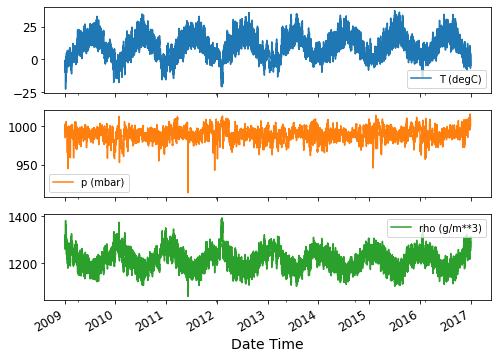

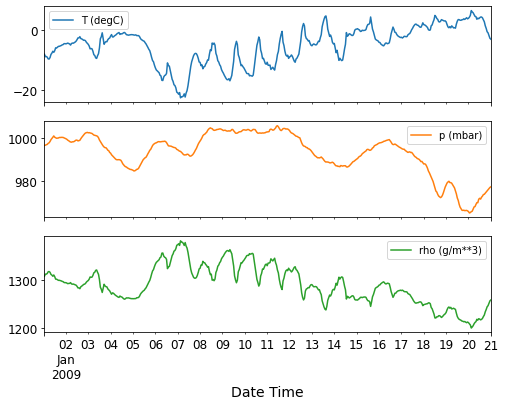

In [ ]:
print("Graphical representation of the dataset")
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

##Inspect and cleanup

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

##Time

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

##Split and normalize the data

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

##Data Windowing class (plot / split window)

In [ ]:
## Functions copied from Google

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

###Make dataset

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

##Define Baseline and compile_and_fit

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

## output = -1, feature = 1 (temp)
def last_time_step_mse(Y_true, Y_pred):
   return keras.metrics.mean_squared_error(Y_true[-1, 1], Y_pred[-1, 1])

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#Part I

This part will contain the following:


*   Description of the data processing from the prelude
*   Reflect on the different between using loss vs other preformance metrics
*   Train a simple LSTM model
*   Improve my LSTM model
*   Analysis




##Descript of the data processing

**Importing the dataset**

TensorFlow imported a CSV of a weather dataset: measuring features over a period of time, e.g. Wind velocity (m/s) at different intervals.

**Data Cleaning**

The data has been cleaned to remove invalid reads:

*   -9999.0 wind velocity, which is an erronous, is replaced by 0.0 as we only want to measure speed and not direction. Direction is engineered in the following part: Feature Engineering.


**Feature engineering**

Wind direction is measured in degrees but must be converted to radians in order to have a wind vector, X and Y to indicate direction.

Time is also provided in seconds. However, we want to measure days and months. In order to do so, numbers are multipled to different time periods (e.g. seconds --> Days). Then using sin and cosine to fill the hours in days, for example, by encoding a continuous cyclic feature.


##Measure using loss functions

Accuracy is a preformance metric that measure number of correct / error. This isn't very useful in predicting as when it comes indentifying images, for example. Identifying images is true or false, it is a shirt or not. However, our model is trying to predict values. Loss measures on the the distance between the true values of the problem and the values predicted by the model. The greater the loss, the huger the error is. Loss function is thus more apt for prediction, where we focus on measuring the divergence rather than spot on predictions.

Mean squared error loss (MSE) is used in the tutorial. MSE is the go to loss function in regression problems. MSE has the benefit of penalizing large errors as the loss is squared, rather than Mean absolute error loss (MAE). This also fits well with this scenario, where we want to penalize

##Train a simple LSTM model

###Define the window

In [ ]:
simple_window = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])

simple_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

###Training the simple model

In [ ]:
simple_model = keras.models.Sequential([
    keras.layers.LSTM(24, input_shape=(24, 18)),
    keras.layers.Dense(1)
])

simple_history = compile_and_fit(simple_model, simple_window)

print("\n\nTraining Ended\n\nEvaluation")
simple_model.evaluate(simple_window.val)
print("\n\nEvaluation, Verbose = 0")
simple_model.evaluate(simple_window.test, verbose=0)

Epoch 1/20
1532/1532 [==============================] - 21s 7ms/step - loss: 0.1287 - mean_absolute_error: 0.2775 - val_loss: 0.1225 - val_mean_absolute_error: 0.2722
Epoch 2/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1105 - mean_absolute_error: 0.2586 - val_loss: 0.1203 - val_mean_absolute_error: 0.2709
Epoch 3/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1051 - mean_absolute_error: 0.2524 - val_loss: 0.1197 - val_mean_absolute_error: 0.2699
Epoch 4/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.1004 - mean_absolute_error: 0.2468 - val_loss: 0.1223 - val_mean_absolute_error: 0.2734
Epoch 5/20
1532/1532 [==============================] - 13s 8ms/step - loss: 0.0957 - mean_absolute_error: 0.2410 - val_loss: 0.1233 - val_mean_absolute_error: 0.2747


Training Ended

Evaluation
437/437 [==============================] - 2s 6ms/step - loss: 0.1233 - mean_absolute_error: 0.2747


Evaluation, Verbose = 0


[0.10180233418941498, 0.2503214478492737]

###Baseline our single-step, single feature results

In [ ]:
ss_baseline = Baseline(label_index=column_indices['T (degC)'])

ss_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = ss_baseline.evaluate(simple_window.val)
performance['Baseline'] = ss_baseline.evaluate(simple_window.test, verbose=0)

437/437 [==============================] - 2s 3ms/step - loss: 0.3575 - mean_absolute_error: 0.4625


##Improved model

In [ ]:
improved_model = keras.models.Sequential([
    keras.layers.GRU(8, return_sequences=True, input_shape=(24, 18)),
    keras.layers.Dense(1)
])

improved_history = compile_and_fit(improved_model, simple_window)

print("\n\nTraining Ended\n\nEvaluation")
val_performance['Improved'] = ss_baseline.evaluate(simple_window.val)
performance['Improved'] = ss_baseline.evaluate(simple_window.test, verbose=0)

Epoch 1/20
1532/1532 [==============================] - 13s 8ms/step - loss: 0.2451 - mean_absolute_error: 0.3877 - val_loss: 0.1770 - val_mean_absolute_error: 0.3317
Epoch 2/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1712 - mean_absolute_error: 0.3248 - val_loss: 0.1596 - val_mean_absolute_error: 0.3144
Epoch 3/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1615 - mean_absolute_error: 0.3145 - val_loss: 0.1570 - val_mean_absolute_error: 0.3128
Epoch 4/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1584 - mean_absolute_error: 0.3114 - val_loss: 0.1567 - val_mean_absolute_error: 0.3117
Epoch 5/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1562 - mean_absolute_error: 0.3091 - val_loss: 0.1558 - val_mean_absolute_error: 0.3114
Epoch 6/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1544 - mean_absolute_error: 0.3072 - val_loss: 0.1565 - val_mean_absolute_error: 0.312

###Analysis of the improved model

Simple model -> loss: 0.1114 - mean_absolute_error: 0.2542

I tried multiple vairants, but the results were simple to my simple model, there wan't any change.

*   **LSTM(48, return_sequence, stateful=True, bias_reg=L2(l2=0.1)), LSTM(24), Dense(1)** -> loss: 0.0978 - mean_absolute_error: 0.2235 - epoch: 18
*   **LSTM(48, return_sequence), LSTM(24), Dense(1)** -> loss: 0.1114 - mean_absolute_error: 0.2545 - epoch: 15
*   **LSTM(48, return_sequence), Bidirectional.LSTM(24), Dense(1)** -> loss: 0.1113 - mean_absolute_error: 0.2542 - epoch: 12
*   **LSTM(48, return_sequence, kernel_reg=L1L2(0.0,0.1)), Bidirectional.LSTM(24), Dense(1)** -> loss: 0.1263 - mean_absolute_error: 0.2748 - epoch: 13


The result were ever so slightly worse than the simple model. The result doesn't seem to improve. However the trainig is very stagnant: it reaches the optimal result for the training and stays at the level. I will try to adjust the nodes

**increasing the nodes**

* **LSTM(128, return_sequence), Bidirectional.LSTM(24), Dense(1)-> loss: 0.1114 - mean_absolute_error: 0.2543**

As results began to dip, i think i was adjusted in the wrong direction.


**Decreasing the nodes**

*    **LSTM(8, return_sequence), Dense(1)-> loss: 0.0057 - mean_absolute_error: 0.0519**

Decreasing the nodes immensly improved my training. I consequently need to retest manipulating the layers combined with the newfound result

* **LSTM(8, return_sequence), SimpleRNN(1)-> loss: 0.1525 - mean_absolute_error: 0.2862**
* **LSTM(8, return_sequence), SimpleRNN(4), Dense(1)-> loss: 0.1123 - mean_absolute_error: 0.2558**
* **LSTM(8, return_sequence), Bidirectional.LSTM(1), Dense(1)-> loss: 0.1114 - mean_absolute_error: 0.2545**

I tried using simpleRNN and Bidirectional, l made this model preform poorly.


**GRU**

* **GRU(8, return_sequence), SimpleRNN(1)-> loss: 0.0057 - mean_absolute_error: 0.0517**

The result is the same with a negligable error margin of 0.0002. The graph seems to also be similar, both failing in the sharp changes in tempurature.


**Test Summary**

Manipulating layers, nodes, regulization and changing to GRU haven't achieved any improvement. The simple model is the improved model.



##Visualize the training

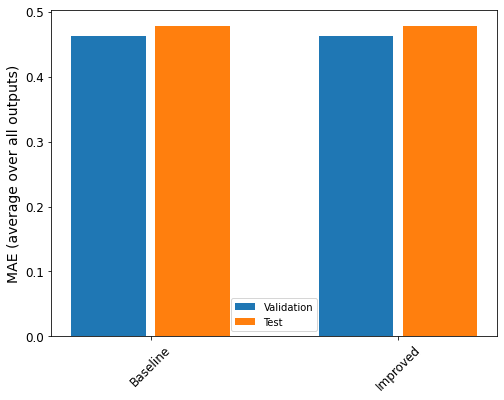

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = improved_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()



In [ ]:
#Tensorflow's code
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.4787
Improved       : 0.4787


#Part II

This part will contain the following:


* Predict a single value of a single feature, 24 hours in advance.
* Predict all values of a single feature, 24 hours in advance
* Analysis



##Single-step predicition

### Define window and model, fit and evalutate

In [ ]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])

w2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2_model = keras.models.Sequential([
    keras.layers.LSTM(32, kernel_regularizer= keras.regularizers.L1L2(l1=0.0, l2=0.1), input_shape=(24, 18)),
    keras.layers.Dense(1)
])

w2_history = compile_and_fit(w2_model, w2, 4)

print("\n\nTraining Ended\n\nEvaluation")
w2_model.evaluate(w2.val)
print("\n\nEvaluation, Verbose = 0")
w2_model.evaluate(w2.test, verbose=0)

Epoch 1/20
1532/1532 [==============================] - 13s 8ms/step - loss: 0.3392 - mean_absolute_error: 0.2964 - val_loss: 0.1454 - val_mean_absolute_error: 0.2860
Epoch 2/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1413 - mean_absolute_error: 0.2841 - val_loss: 0.1385 - val_mean_absolute_error: 0.2824
Epoch 3/20
1532/1532 [==============================] - 13s 8ms/step - loss: 0.1377 - mean_absolute_error: 0.2807 - val_loss: 0.1355 - val_mean_absolute_error: 0.2800
Epoch 4/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1356 - mean_absolute_error: 0.2786 - val_loss: 0.1329 - val_mean_absolute_error: 0.2760
Epoch 5/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.1332 - mean_absolute_error: 0.2763 - val_loss: 0.1338 - val_mean_absolute_error: 0.2774
Epoch 6/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1310 - mean_absolute_error: 0.2739 - val_loss: 0.1343 - val_mean_absolute_error: 0.277

[0.11796959489583969, 0.26690447330474854]

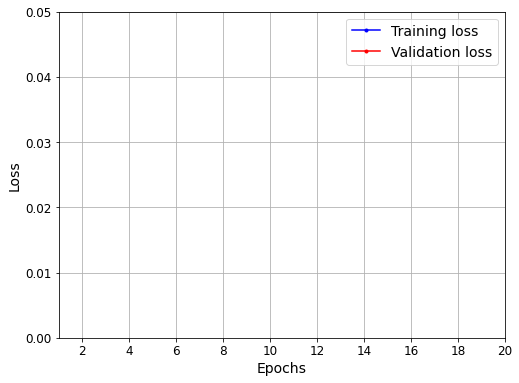

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(w2_history.history["loss"], w2_history.history["val_loss"])
plt.show()

### Baseline our multi-step results

437/437 [==============================] - 2s 4ms/step - loss: 0.1377 - mean_absolute_error: 0.2835


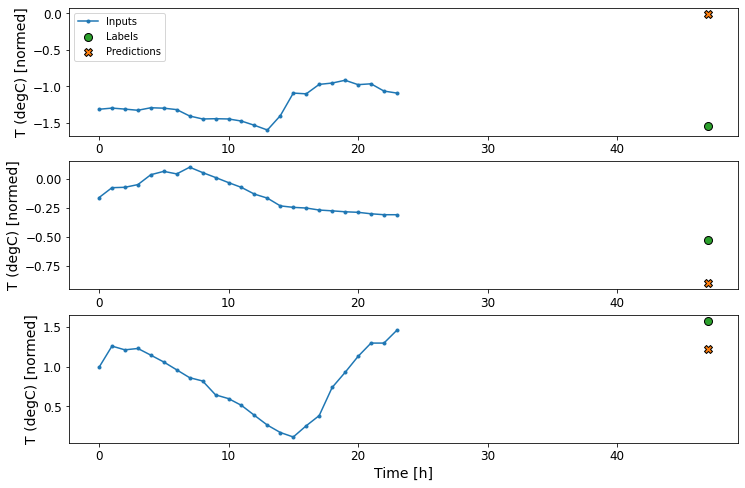

In [ ]:
# Even though this is a single step, baselining the result alongside
# the coming models can be beneficial in understanding the effect of sling shot and autoregressive predicitions

ms_baseline = MultiStepLastBaseline()
ms_baseline.compile(loss='mse',
                      metrics=[last_time_step_mse])

ms_val_performance = {}
ms_performance = {}

OUT_STEPS = 1

ms_val_performance['MS-T'] = w2_model.evaluate(w2.val)
ms_performance['MS-T'] = w2_model.evaluate(w2.test, verbose=0)

w2.plot(ms_baseline)

###Test report

Compared to direct prediction of the value at t =25, it is much more accuract than predicting the temperature at t = 48.

* LSTM(8), Dense(1)-> loss: 0.1307 - mean_absolute_error: 0.2826

The prediction graphed showed no pattern in how the machine predicted the temperature. I believe the model doesn't manage to pick up on that temperature is cyclic, increases and decreased thought the day. The model tends to pick up on the development of the graph, whether it is generally decreasing or increasing. Building on that, it continues the trend. Thus, the predicitions are often much lower or higher than the day before.

The MSE should in theory be the driving force in mainting the prediciton not too far off from what the temperature was at t=25, but there prediciton are way off then they shoudl be.

I tried increasing the kernal size and kernal_intializers

* **LSTM(32), Dense(1) -> loss: 0.1262 - mean_absolute_error: 0.2794**
* **LSTM(32), Dense(1, kernal_intializer = zero()) -> loss: 0.1288 - mean_absolute_error: 0.2797**

I realized that i was only getting roughly 3 to 4 epochs before the earl_stopping is being called. Currently my patience is defaulted at 2, i will increase it to 4 and see the results.

* **LSTM(32), Dense(1) -> loss: 0.1620 - mean_absolute_error: 0.3173, epochs: 13**
* **LSTM(8), Dense(1)->  loss: 0.1191 - mean_absolute_error: 0.2703, epochs 18**

The model was overfitting. Even though the MAE was decreasing still at 8 and 15 epochs, the model began to overfit, which could be send in fluctuation and stagnation of the MAE.

On the previous models in part I, regulaization wasn't helping as the model wasn't overfitting. As both the LSTM(32) and  LSTM(8) are overfitting, i will add regulization to attempt to increase the training epochs and avoid overfitting.

* **LSTM(32, kernal_reg = L1L2(l1=0.0, l2=0.1)), Dense(1) -> loss: 0.1334 - mean_absolute_error: 0.2761, epochs: 8**

* **LSTM(32, kernal_reg = L1L2(l1=0.0, l2=0.1)), RNN(LSTM,bias_reg = L1(l1=1e-4)), Dense(1) -> loss: 0.2132 - mean_absolute_error: 0.3123, epochs: 11**

##Multi-step prediction w/o feedback (single shot predictions)

### Define window and model, fit and evalutate

In [ ]:
w3 = WindowGenerator(input_width=24, label_width=24, shift=24,
                     label_columns=['T (degC)'])

w3

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

In [ ]:
OUT_STEPS = 24
num_features = 18

w3_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

w3_model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

w3_history = w3_model.fit(w3.train, epochs=20,
                    validation_data=w3.val,
                    callbacks=[early_stopping])

print("\n\nTraining Ended\n\nEvaluation")
w3_model.evaluate(w3.val)
print("\n\nEvaluation, Verbose = 0")
w3_model.evaluate(w3.test, verbose=0)

Epoch 1/20
1532/1532 [==============================] - 14s 8ms/step - loss: 0.1193 - last_time_step_mse: 0.0678 - val_loss: 0.0835 - val_last_time_step_mse: 0.0254
Epoch 2/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.0727 - last_time_step_mse: 0.0235 - val_loss: 0.0780 - val_last_time_step_mse: 0.0190
Epoch 3/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0680 - last_time_step_mse: 0.0195 - val_loss: 0.0772 - val_last_time_step_mse: 0.0155
Epoch 4/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.0653 - last_time_step_mse: 0.0166 - val_loss: 0.0784 - val_last_time_step_mse: 0.0149
Epoch 5/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0632 - last_time_step_mse: 0.0156 - val_loss: 0.0768 - val_last_time_step_mse: 0.0132
Epoch 6/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.0614 - last_time_step_mse: 0.0160 - val_loss: 0.0791 - val_last_time_step_mse: 0.0156
Epoch 7/20

[0.06809986382722855, 0.016359172761440277]

### Add to multi-step baseline

437/437 [==============================] - 2s 4ms/step - loss: 0.0799 - last_time_step_mse: 0.0167


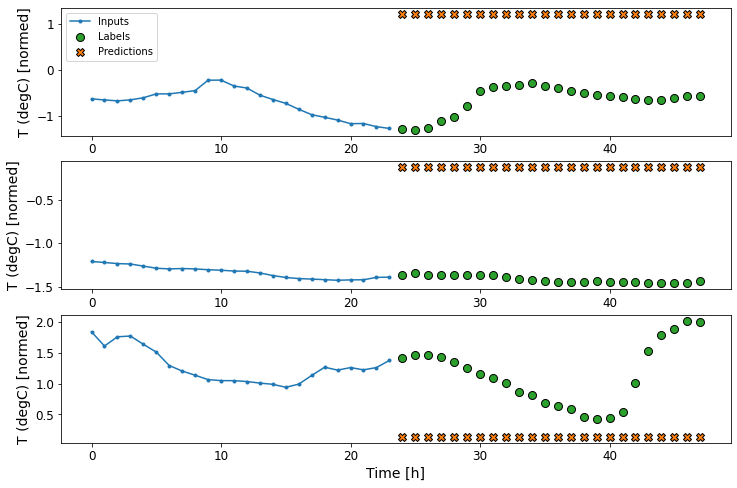

In [ ]:
#Definition is found in Part II > Multi-step prediciton > Basline our multistep results

OUT_STEPS = 24

ms_val_performance['No feedback'] = w3_model.evaluate(w3.val)
ms_performance['No feedback'] = w3_model.evaluate(w3.test, verbose=0)

w3.plot(ms_baseline)

###Test report

Sling shot prediction has achieved a much lower MSE than a direct prediction.

* **LSTM(32), Dense(18, kernal_intializer = 0)-> loss: 0.0767 - last_time_step_mse: 0.0156**


* **LSTM(32), Dense(18) -> loss: 0.0862 - mean_absolute_error: 0.0214**

I tried to add regulization even though there was no sign of overfitting. I was hoping i could increase the size fo the LSTM

* **LSTM(48, kernal_reg = L1L2(l1=0.0, l2=0.1)), Dense(1) -> loss: 0.0534 - mean_absolute_error: 0.0361, epochs: 8**

* **LSTM(48, kernal_reg = L1L2(l1=0.0, l2=0.1)), RNN(LSTM,bias_reg = L1(l1=1e-4)), Dense(1) -> loss: 0.3132 - mean_absolute_error: 0.2123, epochs: 11**


**LSTM(32) or smaller(16,8)** fit much better. It doesn't seem that any of the models really need regulization. The most beneficial is keeping the LSTM relativelly small.


#Part III

* Predict multiple values using feedback

##Multi-step prediction with feedback (autoregressive predictions)



In [ ]:
#Tensorflow's code
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


In [ ]:
feedback_window = WindowGenerator(input_width=24, label_width=24, shift=24)

feedback_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [ ]:
feedback_model = FeedBack(units=32, out_steps=24)

prediction, state = feedback_model.warmup(feedback_window.example[0])
prediction.shape

TensorShape([32, 18])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

feedback_model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

feedback_history = feedback_model.fit(feedback_window.train, epochs=20,
                    validation_data=feedback_window.val,
                    callbacks=[early_stopping])

print("\n\nTraining Ended\n\nEvaluation")
feedback_model.evaluate(feedback_window.val)
print("\n\nEvaluation, Verbose = 0")
feedback_model.evaluate(feedback_window.test, verbose=0)

Epoch 1/20
1532/1532 [==============================] - 94s 59ms/step - loss: 0.2955 - last_time_step_mse: 0.2373 - val_loss: 0.2448 - val_last_time_step_mse: 0.1480
Epoch 2/20
1532/1532 [==============================] - 80s 52ms/step - loss: 0.2223 - last_time_step_mse: 0.1316 - val_loss: 0.2395 - val_last_time_step_mse: 0.1332
Epoch 3/20
1532/1532 [==============================] - 79s 51ms/step - loss: 0.2136 - last_time_step_mse: 0.1202 - val_loss: 0.2288 - val_last_time_step_mse: 0.1232
Epoch 4/20
1532/1532 [==============================] - 78s 51ms/step - loss: 0.2089 - last_time_step_mse: 0.1168 - val_loss: 0.2256 - val_last_time_step_mse: 0.1116
Epoch 5/20
1532/1532 [==============================] - 77s 50ms/step - loss: 0.2053 - last_time_step_mse: 0.1137 - val_loss: 0.2226 - val_last_time_step_mse: 0.1214
Epoch 6/20
1532/1532 [==============================] - 77s 50ms/step - loss: 0.2032 - last_time_step_mse: 0.1191 - val_loss: 0.2208 - val_last_time_step_mse: 0.1180
Epoc

[0.19279398024082184, 0.10131919384002686]

###Add to multi-step baseline

437/437 [==============================] - 4s 10ms/step - loss: 0.2219 - last_time_step_mse: 0.1253


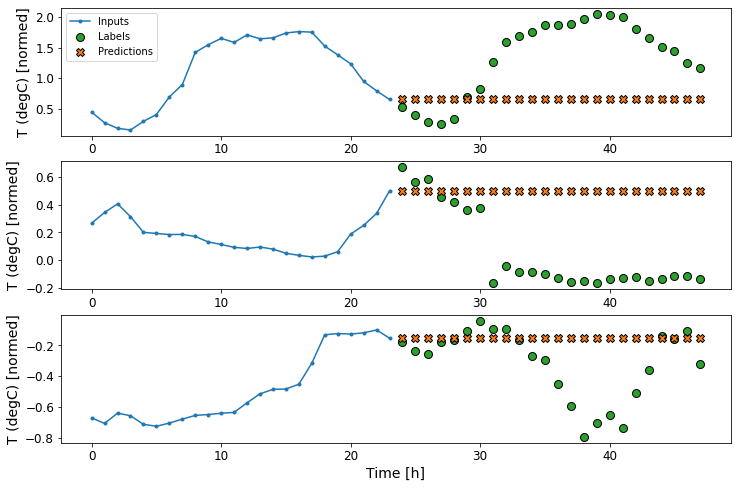

In [ ]:
ms_val_performance['With feedback'] = feedback_model.evaluate(feedback_window.val)
ms_performance['With feedback'] = feedback_model.evaluate(feedback_window.test, verbose = 0)

OUT_STEPS = 24

feedback_window.plot(ms_baseline)

###Test report


This model has an lstm layer wrapped in RNN, to "simplify the `warmup` method". This has proven to be less effective

* lSTM(32), RNN(LSTM, return state), Dense (Softmax) -> - loss: 0.2219 - last_time_step_mse: 0.1253

This addition of the RNN makes it harder to compare this to the previous model. I tried adding RNN to other models, but the result was a drop in preformance.

However, this could be also indicate that the other features have affected negatively the prediction of weather or that weather is harder to predict than the other 17 features

Looking at the prediction parallel to the original values, it seem that the machine is just replicating the trend, this is as aforementioned because of only 24 hours to learn from. (I removed the graph)

The prediction graphed showed the model understood that the temperature is cyclic, increases and decreased thought the day. This could be because it learns from multiple features (18 features compared to 1), that there is some sort of cycle.

The MSE could more easily help in mainting the prediciton not too far off from what the temperature was at t=25 and thats mostly thanks to additional features to also add to the penalization of wrong answers.





##Comparing Part II and Part II results

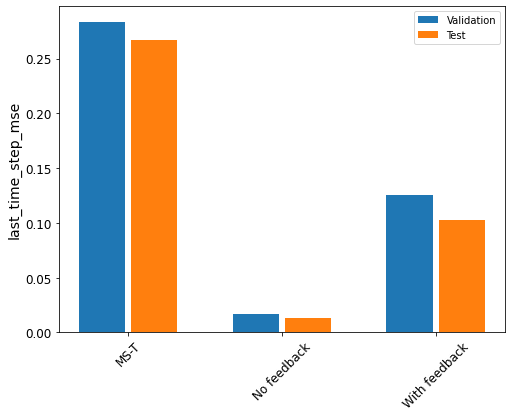

In [ ]:
#Tensorflow's code
x = np.arange(len(ms_performance))
width = 0.3

metric_name = 'last_time_step_mse'
metric_index = feedback_model.metrics_names.index('last_time_step_mse')
val_mae = [v[metric_index] for v in ms_val_performance.values()]
test_mae = [v[metric_index] for v in ms_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=ms_performance.keys(),
           rotation=45)
plt.ylabel('last_time_step_mse')
_ = plt.legend()

In [ ]:
#Tensorflow's code
for name, value in ms_performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

MS-T           : 0.2669
No feedback    : 0.0128
With feedback  : 0.1027
